# Problem 1: Language Modeling with RNNs
* <b>Learning Objective:</b> In this problem, you are going to implement simple recurrent neural networks to deeply understand how RNNs works.
* <b>Provided Code:</b> We provide the skeletons of classes you need to complete. Forward checking and gradient checkings are provided for verifying your implementation as well.
* <b>TODOs:</b> you will firstly implement a vanilla RNN to get warm up, and then implement an LSTM to train a model that can generate text using your own text source (novel, lyrics etc).

In [1]:
from lib.rnn import *
from lib.layer_utils import *
from lib.grad_check import *
from lib.optim import *
from lib.train import *
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Recurrent Neural Networks
We will use recurrent neural network (RNN) language models for text generation.

Please complete the TODOs in the function `VanillaRNN` of the file `lib/layer_utils.py` which should contain implementations of different layer types that are needed for recurrent neural networks.

And then, complete the TODOs in the file `lib/rnn.py` which uses these layers to implement an text generation model.

# Vanilla RNN: step forward
Open the file `lib/layer_utils.py`. Implement the forward and backward passes for different types of layers that are commonly used in recurrent neural networks.

First complete the implementation of the function `step_forward` which implements the forward pass for a single timestep of a vanilla recurrent neural network.

After doing so run the following code. You should see errors less than 1e-8.

In [2]:
%reload_ext autoreload

N, D, H = 3, 10, 4

rnn = VanillaRNN(D, H, init_scale=0.02, name="rnn_test")
x = np.linspace(-0.4, 0.7, num=N*D).reshape(N, D)
prev_h = np.linspace(-0.2, 0.5, num=N*H).reshape(N, H)

rnn.params[rnn.wx_name] = np.linspace(-0.1, 0.9, num=D*H).reshape(D, H)
rnn.params[rnn.wh_name] = np.linspace(-0.3, 0.7, num=H*H).reshape(H, H)
rnn.params[rnn.b_name] = np.linspace(-0.2, 0.4, num=H)

next_h, _ = rnn.step_forward(x, prev_h)
expected_next_h = np.asarray([
  [-0.58172089, -0.50182032, -0.41232771, -0.31410098],
  [ 0.66854692,  0.79562378,  0.87755553,  0.92795967],
  [ 0.97934501,  0.99144213,  0.99646691,  0.99854353]])

print('next_h error: ', rel_error(expected_next_h, next_h))

next_h error:  6.292421426471037e-09


# Vanilla RNN: step backward
In the `VanillaRNN` class in the file `lib/layer_utils.py` complete the `step_backward` function.

After doing so run the following to numerically gradient check the implementation. You should see errors less than `1e-8`.

In [3]:
%reload_ext autoreload

np.random.seed(231)
N, D, H = 4, 5, 6

rnn = VanillaRNN(D, H, init_scale=0.02, name="rnn_test")

x = np.random.randn(N, D)
h = np.random.randn(N, H)
Wx = np.random.randn(D, H)
Wh = np.random.randn(H, H)
b = np.random.randn(H)

rnn.params[rnn.wx_name] = Wx
rnn.params[rnn.wh_name] = Wh
rnn.params[rnn.b_name] = b

out, meta = rnn.step_forward(x, h)

dnext_h = np.random.randn(*out.shape)

dx_num = eval_numerical_gradient_array(lambda x: rnn.step_forward(x, h)[0], x, dnext_h)
dprev_h_num = eval_numerical_gradient_array(lambda h: rnn.step_forward(x, h)[0], h, dnext_h)
dWx_num = eval_numerical_gradient_array(lambda Wx: rnn.step_forward(x, h)[0], Wx, dnext_h)
dWh_num = eval_numerical_gradient_array(lambda Wh: rnn.step_forward(x, h)[0], Wh, dnext_h)
db_num = eval_numerical_gradient_array(lambda b: rnn.step_forward(x, h)[0], b, dnext_h)

dx, dprev_h, dWx, dWh, db = rnn.step_backward(dnext_h, meta)

print('dx error: ', rel_error(dx_num, dx))
print('dprev_h error: ', rel_error(dprev_h_num, dprev_h))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  5.473855898318782e-10
dprev_h error:  3.2228854474240573e-10
dWx error:  1.264200416692046e-10
dWh error:  3.1863456358952086e-10
db error:  1.655233896888798e-11


# Vanilla RNN: forward
Now that you have  completed the forward and backward passes for a single timestep of a vanilla RNN, you will see how they are combined to implement a RNN that process an entire sequence of data.

In the `VanillaRNN` class in the file `lib/layer_utils.py`, complete the function `forward`. This is implemented using the `step_forward` function that you defined above.

After doing so run the following to check the implementation. You should see errors less than `1e-7`.

In [4]:
%reload_ext autoreload

N, T, D, H = 2, 3, 4, 5

rnn = VanillaRNN(D, H, init_scale=0.02, name="rnn_test")

x = np.linspace(-0.1, 0.3, num=N*T*D).reshape(N, T, D)
h0 = np.linspace(-0.3, 0.1, num=N*H).reshape(N, H)
Wx = np.linspace(-0.2, 0.4, num=D*H).reshape(D, H)
Wh = np.linspace(-0.4, 0.1, num=H*H).reshape(H, H)
b = np.linspace(-0.7, 0.1, num=H)

rnn.params[rnn.wx_name] = Wx
rnn.params[rnn.wh_name] = Wh
rnn.params[rnn.b_name] = b

h = rnn.forward(x, h0)
expected_h = np.asarray([
  [
    [-0.42070749, -0.27279261, -0.11074945,  0.05740409,  0.22236251],
    [-0.39525808, -0.22554661, -0.0409454,   0.14649412,  0.32397316],
    [-0.42305111, -0.24223728, -0.04287027,  0.15997045,  0.35014525],
  ],
  [
    [-0.55857474, -0.39065825, -0.19198182,  0.02378408,  0.23735671],
    [-0.27150199, -0.07088804,  0.13562939,  0.33099728,  0.50158768],
    [-0.51014825, -0.30524429, -0.06755202,  0.17806392,  0.40333043]]])

print('h error: ', rel_error(expected_h, h))

h error:  7.728466151011529e-08


# Vanilla RNN: backward
In the file `lib/layer_utils.py`, complete the backward pass for a vanilla RNN in the function `backward` in the `VanillaRNN` class. This runs back-propagation over the entire sequence, calling into the `step_backward` function defined above.

You should see errors less than 5e-7.

In [5]:
%reload_ext autoreload

np.random.seed(231)

N, D, T, H = 2, 3, 10, 5

rnn = VanillaRNN(D, H, init_scale=0.02, name="rnn_test")

x = np.random.randn(N, T, D)
h0 = np.random.randn(N, H)
Wx = np.random.randn(D, H)
Wh = np.random.randn(H, H)
b = np.random.randn(H)

rnn.params[rnn.wx_name] = Wx
rnn.params[rnn.wh_name] = Wh
rnn.params[rnn.b_name] = b

out = rnn.forward(x, h0)

dout = np.random.randn(*out.shape)

dx, dh0 = rnn.backward(dout)

dx_num = eval_numerical_gradient_array(lambda x: rnn.forward(x, h0), x, dout)
dh0_num = eval_numerical_gradient_array(lambda h0: rnn.forward(x, h0), h0, dout)
dWx_num = eval_numerical_gradient_array(lambda Wx: rnn.forward(x, h0), Wx, dout)
dWh_num = eval_numerical_gradient_array(lambda Wh: rnn.forward(x, h0), Wh, dout)
db_num = eval_numerical_gradient_array(lambda b: rnn.forward(x, h0), b, dout)

dWx = rnn.grads[rnn.wx_name]
dWh = rnn.grads[rnn.wh_name]
db = rnn.grads[rnn.b_name]

print('dx error: ', rel_error(dx_num, dx))
print('dh0 error: ', rel_error(dh0_num, dh0))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  2.343410197870515e-08
dh0 error:  7.862318687700144e-10
dWx error:  2.0785873022566864e-08
dWh error:  1.485440873402469e-08
db error:  3.399954332784714e-10


# Word embedding: forward
In deep learning systems, we commonly represent words using vectors. Each word of the vocabulary will be associated with a vector, and these vectors will be learned jointly with the rest of the system.

In the file `lib/layer_utils.py`, implement the function `forward` in the `word_embedding` class to convert words (represented by integers) into vectors. Run the following to check the implementation. You should see error around `1e-8`.

In [6]:
%reload_ext autoreload

N, T, V, D = 2, 4, 5, 3

we = word_embedding(V, D, name="we")

x = np.asarray([[0, 3, 1, 2], [2, 1, 0, 3]])
W = np.linspace(0, 1, num=V*D).reshape(V, D)

we.params[we.w_name] = W

out = we.forward(x)
expected_out = np.asarray([
 [[ 0.,          0.07142857,  0.14285714],
  [ 0.64285714,  0.71428571,  0.78571429],
  [ 0.21428571,  0.28571429,  0.35714286],
  [ 0.42857143,  0.5,         0.57142857]],
 [[ 0.42857143,  0.5,         0.57142857],
  [ 0.21428571,  0.28571429,  0.35714286],
  [ 0.,          0.07142857,  0.14285714],
  [ 0.64285714,  0.71428571,  0.78571429]]])

print('out error: ', rel_error(expected_out, out))

out error:  1.0000000094736443e-08


# Word embedding: backward
Implement the backward pass for the word embedding function in the function `backward` in the `word_embedding` class. After doing so run the following to numerically gradient check your implementation. You should see errors less than `1e-11`.

In [7]:
%reload_ext autoreload

np.random.seed(231)

N, T, V, D = 50, 3, 5, 6

we = word_embedding(V, D, name="we")

x = np.random.randint(V, size=(N, T))
W = np.random.randn(V, D)

we.params[we.w_name] = W

out = we.forward(x)
dout = np.random.randn(*out.shape)
we.backward(dout)

dW = we.grads[we.w_name]

f = lambda W: we.forward(x)
dW_num = eval_numerical_gradient_array(f, W, dout)

print('dW error: ', rel_error(dW, dW_num))

dW error:  3.2759440934795915e-12


# Temporal Fully Connected layer
At every timestep we use an affine function to transform the RNN hidden vector at that timestep into scores for each word in the vocabulary. Because this is very similar to the fully connected layer that you implemented in assignment 1, we have provided this function for you in the `forward` and `backward` functions in the file `lib/layer_util.py`. Run the following to perform numeric gradient checking on the implementation. You should see errors less than 1e-9.

In [8]:
%reload_ext autoreload

np.random.seed(231)

# Gradient check for temporal affine layer
N, T, D, M = 2, 3, 4, 5

t_fc = temporal_fc(D, M, init_scale=0.02, name='test_t_fc')

x = np.random.randn(N, T, D)
w = np.random.randn(D, M)
b = np.random.randn(M)

t_fc.params[t_fc.w_name] = w
t_fc.params[t_fc.b_name] = b

out = t_fc.forward(x)

dout = np.random.randn(*out.shape)

dx_num = eval_numerical_gradient_array(lambda x: t_fc.forward(x), x, dout)
dw_num = eval_numerical_gradient_array(lambda w: t_fc.forward(x), w, dout)
db_num = eval_numerical_gradient_array(lambda b: t_fc.forward(x), b, dout)

dx = t_fc.backward(dout)
dw = t_fc.grads[t_fc.w_name]
db = t_fc.grads[t_fc.b_name]

print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

dx error:  3.2269470390098687e-10
dw error:  3.8595619942595054e-11
db error:  1.1455396263586309e-11


# Temporal Softmax loss
In an RNN language model, at every timestep we produce a score for each word in the vocabulary. We know the ground-truth word at each timestep, so we use a softmax loss function to compute loss and gradient at each timestep. We sum the losses over time and average them over the minibatch.

We provide this loss function for you; look at the `temporal_softmax_loss` function in the file `lib/layer_utils.py`.

Run the following cell to sanity check the loss and perform numeric gradient checking on the function. You should see an error for dx less than 1e-7.

In [9]:
%reload_ext autoreload

loss_func = temporal_softmax_loss()

# Sanity check for temporal softmax loss
N, T, V = 100, 1, 10

def check_loss(N, T, V, p):
    x = 0.001 * np.random.randn(N, T, V)
    y = np.random.randint(V, size=(N, T))
    mask = np.random.rand(N, T) <= p
    print(loss_func.forward(x, y, mask))
  
check_loss(100, 1, 10, 1.0)   # Should be about 2.3
check_loss(100, 10, 10, 1.0)  # Should be about 23
check_loss(5000, 10, 10, 0.1) # Should be about 2.3

# Gradient check for temporal softmax loss
N, T, V = 7, 8, 9

x = np.random.randn(N, T, V)
y = np.random.randint(V, size=(N, T))
mask = (np.random.rand(N, T) > 0.5)

loss = loss_func.forward(x, y, mask)
dx = loss_func.backward()

dx_num = eval_numerical_gradient(lambda x: loss_func.forward(x, y, mask), x, verbose=False)

print('dx error: ', rel_error(dx, dx_num))

2.3026547279318357
23.026307039328714
2.2989009292538665
dx error:  4.0464746298031226e-08


# RNN for language modeling
Now that you have the necessary layers, you can combine them to build a language modeling model. Open the file `lib/rnn.py` and look at the `TestRNN` class.

Check the forward and backward pass of the model in the `loss` function. For now you only see the implementation of the case where `cell_type='rnn'` for vanilla RNNs; you will implement the LSTM case later. After doing so, run the following to check the forward pass using a small test case; you should see error less than `1e-10`.

In [10]:
%reload_ext autoreload

N, D, H = 10, 20, 40
V = 4
T = 13

model = TestRNN(D, H, cell_type='rnn')
loss_func = temporal_softmax_loss()

# Set all model parameters to fixed values
for k, v in model.params.items():
    model.params[k] = np.linspace(-1.4, 1.3, num=v.size).reshape(*v.shape)
model.assign_params()

features = np.linspace(-1.5, 0.3, num=(N * D * T)).reshape(N, T, D)
h0 = np.linspace(-1.5, 0.5, num=(N*H)).reshape(N, H)
labels = (np.arange(N * T) % V).reshape(N, T)

pred = model.forward(features, h0)

# You'll need this
mask = np.ones((N, T))

loss = loss_func.forward(pred, labels, mask)
dLoss = loss_func.backward()

expected_loss = 51.0949189134

print('loss: ', loss)
print('expected loss: ', expected_loss)
print('difference: ', abs(loss - expected_loss))

loss:  51.094918913361184
expected loss:  51.0949189134
difference:  3.881694965457427e-11


Run the following cell to perform numeric gradient checking on the `TestRNN` class; you should errors around `1e-7` or less.

In [56]:
%reload_ext autoreload

np.random.seed(231)

batch_size = 2
timesteps = 3
input_dim = 4
hidden_dim = 6
label_size = 4

labels = np.random.randint(label_size, size=(batch_size, timesteps))
features = np.random.randn(batch_size, timesteps, input_dim)
h0 = np.random.randn(batch_size, hidden_dim)

model = TestRNN(input_dim, hidden_dim, cell_type='rnn')
loss_func = temporal_softmax_loss()

pred = model.forward(features, h0)

# You'll need this
mask = np.ones((batch_size, timesteps))

loss = loss_func.forward(pred, labels, mask)
dLoss = loss_func.backward()

dout, dh0 = model.backward(dLoss)

grads = model.grads

for param_name in sorted(grads):
    
    f = lambda _: loss_func.forward(model.forward(features, h0), labels, mask)
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print('%s relative error: %e' % (param_name, e))

vanilla_rnn_b relative error: 9.451394e-08
vanilla_rnn_wh relative error: 3.221744e-08
vanilla_rnn_wx relative error: 9.508480e-08


# LSTM
Vanilla RNNs can be tough to train on long sequences due to vanishing and exploding gradiants. LSTMs solve this problem by replacing the simple update rule of the vanilla RNN with a gating mechanism as follows.

Similar to the vanilla RNN, at each timestep we receive an input $x_t\in\mathbb{R}^D$ and the previous hidden state $h_{t-1}\in\mathbb{R}^H$; what is different in the LSTM is to maintain an $H$-dimensional *cell state*, so we also receive the previous cell state $c_{t-1}\in\mathbb{R}^H$. The learnable parameters of the LSTM are an *input-to-hidden* matrix $W_x\in\mathbb{R}^{4H\times D}$, a *hidden-to-hidden* matrix $W_h\in\mathbb{R}^{4H\times H}$ and a *bias vector* $b\in\mathbb{R}^{4H}$.

At each timestep we first compute an *activation vector* $a\in\mathbb{R}^{4H}$ as $a=W_xx_t + W_hh_{t-1}+b$. We then divide this into four vectors $a_i,a_f,a_o,a_g\in\mathbb{R}^H$ where $a_i$ consists of the first $H$ elements of $a$, $a_f$ is the next $H$ elements of $a$, etc. We then compute the *input gate* $g\in\mathbb{R}^H$, *forget gate* $f\in\mathbb{R}^H$, *output gate* $o\in\mathbb{R}^H$ and *gate gate* $g\in\mathbb{R}^H$ as

$$
\begin{align*}
i = \sigma(a_i) \hspace{2pc}
f = \sigma(a_f) \hspace{2pc}
o = \sigma(a_o) \hspace{2pc}
g = \tanh(a_g)
\end{align*}
$$

where $\sigma$ is the sigmoid function and $\tanh$ is the hyperbolic tangent, both applied elementwise.

Finally we compute the next cell state $c_t$ and next hidden state $h_t$ as

$$
c_{t} = f\odot c_{t-1} + i\odot g \hspace{4pc}
h_t = o\odot\tanh(c_t)
$$

where $\odot$ is the elementwise product of vectors.

In the rest of the notebook we will implement the LSTM update rule and apply it to the text generation task. 

In the code, we assume that data is stored in batches so that $X_t \in \mathbb{R}^{N\times D}$, and will work with *transposed* versions of the parameters: $W_x \in \mathbb{R}^{D \times 4H}$, $W_h \in \mathbb{R}^{H\times 4H}$ so that activations $A \in \mathbb{R}^{N\times 4H}$ can be computed efficiently as $A = X_t W_x + H_{t-1} W_h$

# LSTM: step forward
Implement the forward pass for a single timestep of an LSTM in the `step_forward` function in the file `lib/layer_utils.py`. This should be similar to the `step_forward` function that you implemented above, but using the LSTM update rule instead.

Once you are done, run the following to perform a simple test of your implementation. You should see errors around `1e-8` or less.

In [57]:
%reload_ext autoreload

N, D, H = 3, 4, 5

lstm = LSTM(D, H, init_scale=0.02, name='test_lstm')

x = np.linspace(-0.4, 1.2, num=N*D).reshape(N, D)
prev_h = np.linspace(-0.3, 0.7, num=N*H).reshape(N, H)
prev_c = np.linspace(-0.4, 0.9, num=N*H).reshape(N, H)
Wx = np.linspace(-2.1, 1.3, num=4*D*H).reshape(D, 4 * H)
Wh = np.linspace(-0.7, 2.2, num=4*H*H).reshape(H, 4 * H)
b = np.linspace(0.3, 0.7, num=4*H)

lstm.params[lstm.wx_name] = Wx
lstm.params[lstm.wh_name] = Wh
lstm.params[lstm.b_name] = b

next_h, next_c, cache = lstm.step_forward(x, prev_h, prev_c)

expected_next_h = np.asarray([
    [ 0.24635157,  0.28610883,  0.32240467,  0.35525807,  0.38474904],
    [ 0.49223563,  0.55611431,  0.61507696,  0.66844003,  0.7159181 ],
    [ 0.56735664,  0.66310127,  0.74419266,  0.80889665,  0.858299  ]])
expected_next_c = np.asarray([
    [ 0.32986176,  0.39145139,  0.451556,    0.51014116,  0.56717407],
    [ 0.66382255,  0.76674007,  0.87195994,  0.97902709,  1.08751345],
    [ 0.74192008,  0.90592151,  1.07717006,  1.25120233,  1.42395676]])

print('next_h error: ', rel_error(expected_next_h, next_h))
print('next_c error: ', rel_error(expected_next_c, next_c))

next_h error:  5.7054131185818695e-09
next_c error:  5.8143123088804145e-09


# LSTM: step backward
Implement the backward pass for a single LSTM timestep in the function `step_backward` in the file `lib/layer_utils.py`. Once you are done, run the following to perform numeric gradient checking on your implementation. You should see errors around `1e-6` or less.

In [14]:
%reload_ext autoreload

np.random.seed(231)

N, D, H = 4, 5, 6

lstm = LSTM(D, H, init_scale=0.02, name='test_lstm')

x = np.random.randn(N, D)
prev_h = np.random.randn(N, H)
prev_c = np.random.randn(N, H)
Wx = np.random.randn(D, 4 * H)
Wh = np.random.randn(H, 4 * H)
b = np.random.randn(4 * H)

lstm.params[lstm.wx_name] = Wx
lstm.params[lstm.wh_name] = Wh
lstm.params[lstm.b_name] = b

next_h, next_c, cache = lstm.step_forward(x, prev_h, prev_c)


dnext_h = np.random.randn(*next_h.shape)
dnext_c = np.random.randn(*next_c.shape)

fx_h = lambda x: lstm.step_forward(x, prev_h, prev_c)[0]
fh_h = lambda h: lstm.step_forward(x, prev_h, prev_c)[0]
fc_h = lambda c: lstm.step_forward(x, prev_h, prev_c)[0]
fWx_h = lambda Wx: lstm.step_forward(x, prev_h, prev_c)[0]
fWh_h = lambda Wh: lstm.step_forward(x, prev_h, prev_c)[0]
fb_h = lambda b: lstm.step_forward(x, prev_h, prev_c)[0]

fx_c = lambda x: lstm.step_forward(x, prev_h, prev_c)[1]
fh_c = lambda h: lstm.step_forward(x, prev_h, prev_c)[1]
fc_c = lambda c: lstm.step_forward(x, prev_h, prev_c)[1]
fWx_c = lambda Wx: lstm.step_forward(x, prev_h, prev_c)[1]
fWh_c = lambda Wh: lstm.step_forward(x, prev_h, prev_c)[1]
fb_c = lambda b: lstm.step_forward(x, prev_h, prev_c)[1]

num_grad = eval_numerical_gradient_array

dx_num = num_grad(fx_h, x, dnext_h) + num_grad(fx_c, x, dnext_c)
dh_num = num_grad(fh_h, prev_h, dnext_h) + num_grad(fh_c, prev_h, dnext_c)
dc_num = num_grad(fc_h, prev_c, dnext_h) + num_grad(fc_c, prev_c, dnext_c)
dWx_num = num_grad(fWx_h, Wx, dnext_h) + num_grad(fWx_c, Wx, dnext_c)
dWh_num = num_grad(fWh_h, Wh, dnext_h) + num_grad(fWh_c, Wh, dnext_c)
db_num = num_grad(fb_h, b, dnext_h) + num_grad(fb_c, b, dnext_c)

dx, dh, dc, dWx, dWh, db = lstm.step_backward(dnext_h, dnext_c, cache)

print('dx error: ', rel_error(dx_num, dx))
print('dh error: ', rel_error(dh_num, dh))
print('dc error: ', rel_error(dc_num, dc))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  3.390657106134666e-10
dh error:  1.048318037723526e-08
dc error:  1.0127280886420228e-08
dWx error:  1.8944292163912603e-07
dWh error:  1.461752914864933e-07
db error:  1.8671697284523756e-08


# LSTM: forward
In the class `lstm` in the file `lib/layer_utils.py`, implement the `forward` function to run an LSTM forward on an entire timeseries of data.

When you are done, run the following to check your implementation. You should see an error around `1e-7`.

In [15]:
%reload_ext autoreload

N, D, H, T = 2, 5, 4, 3

lstm = LSTM(D, H, init_scale=0.02, name='test_lstm')

x = np.linspace(-0.4, 0.6, num=N*T*D).reshape(N, T, D)
h0 = np.linspace(-0.4, 0.8, num=N*H).reshape(N, H)
Wx = np.linspace(-0.2, 0.9, num=4*D*H).reshape(D, 4 * H)
Wh = np.linspace(-0.3, 0.6, num=4*H*H).reshape(H, 4 * H)
b = np.linspace(0.2, 0.7, num=4*H)

lstm.params[lstm.wx_name] = Wx
lstm.params[lstm.wh_name] = Wh
lstm.params[lstm.b_name] = b

h = lstm.forward(x, h0)

expected_h = np.asarray([
 [[ 0.01764008,  0.01823233,  0.01882671,  0.0194232 ],
  [ 0.11287491,  0.12146228,  0.13018446,  0.13902939],
  [ 0.31358768,  0.33338627,  0.35304453,  0.37250975]],
 [[ 0.45767879,  0.4761092,   0.4936887,   0.51041945],
  [ 0.6704845,   0.69350089,  0.71486014,  0.7346449 ],
  [ 0.81733511,  0.83677871,  0.85403753,  0.86935314]]])

print('h error: ', rel_error(expected_h, h))

h error:  8.610537452106624e-08


# LSTM: backward
Implement the backward pass for an LSTM over an entire timeseries of data in the function `backward` in the `lstm` class in the file `lib/layer_utils.py`. When you are done, run the following to perform numeric gradient checking on your implementation. You should see errors around `1e-7` or less.

In [16]:
%reload_ext autoreload

np.random.seed(231)

N, D, T, H = 2, 3, 10, 6

lstm = LSTM(D, H, init_scale=0.02, name='test_lstm')

x = np.random.randn(N, T, D)
h0 = np.random.randn(N, H)
Wx = np.random.randn(D, 4 * H)
Wh = np.random.randn(H, 4 * H)
b = np.random.randn(4 * H)

lstm.params[lstm.wx_name] = Wx
lstm.params[lstm.wh_name] = Wh
lstm.params[lstm.b_name] = b

out = lstm.forward(x, h0)

dout = np.random.randn(*out.shape)

dx, dh0 = lstm.backward(dout)
dWx = lstm.grads[lstm.wx_name] 
dWh = lstm.grads[lstm.wh_name]
db = lstm.grads[lstm.b_name]

dx_num = eval_numerical_gradient_array(lambda x: lstm.forward(x, h0), x, dout)
dh0_num = eval_numerical_gradient_array(lambda h0: lstm.forward(x, h0), h0, dout)
dWx_num = eval_numerical_gradient_array(lambda Wx: lstm.forward(x, h0), Wx, dout)
dWh_num = eval_numerical_gradient_array(lambda Wh: lstm.forward(x, h0), Wh, dout)
db_num = eval_numerical_gradient_array(lambda b: lstm.forward(x, h0), b, dout)

print('dx error: ', rel_error(dx_num, dx))
print('dh0 error: ', rel_error(dh0_num, dh0))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  1.697574820930658e-09
dh0 error:  2.859333845449481e-10
dWx error:  8.066142552562204e-09
dWh error:  5.143345917927948e-08
db error:  5.485894231688898e-10


# LSTM model

Now that you have implemented an LSTM, update the initialization of the `TestRNN` class in the file `lib/rnn.py` to handle the case where `self.cell_type` is `lstm`. This should require adding only one line of code.

Once you have done so, run the following to check your implementation. You should see a difference of less than `1e-10`.

In [17]:
%reload_ext autoreload

N, D, H = 10, 20, 40
V = 4
T = 13

model = TestRNN(D, H, cell_type='lstm')
loss_func = temporal_softmax_loss()

# Set all model parameters to fixed values
for k, v in model.params.items():
    model.params[k] = np.linspace(-1.4, 1.3, num=v.size).reshape(*v.shape)
model.assign_params()

features = np.linspace(-1.5, 0.3, num=(N * D * T)).reshape(N, T, D)
h0 = np.linspace(-1.5, 0.5, num=(N*H)).reshape(N, H)
labels = (np.arange(N * T) % V).reshape(N, T)

pred = model.forward(features, h0)

# You'll need this
mask = np.ones((N, T))

loss = loss_func.forward(pred, labels, mask)
dLoss = loss_func.backward()

expected_loss = 49.2140256354

print('loss: ', loss)
print('expected loss: ', expected_loss)
print('difference: ', abs(loss - expected_loss))

loss:  49.21402563544293
expected loss:  49.2140256354
difference:  4.293099209462525e-11


# Let's have some fun!!

Now you have everything you need for language modeling. You will work on text generation using RNNs from any text source (novel, lyrics).

The network is trained to predict what word is coming next given a previous word. Once you train the model, by looping the network, you can keep generating a new text which is mimicing the original text source.

We will use one of the most frequently downloaded e-books, Alice's Adventures in Wonderland, from Project Gutenberg, where the original link can be found [here](https://www.gutenberg.org/ebooks/11).

We extracted only the first chapter for the resources saving.

In [60]:
%reload_ext autoreload

input_file = open("data/Harry", "r",encoding="utf8")
input_text = input_file.readlines()
input_text = ''.join(input_text)

simply run the following code to construct training dataset<br />

In [61]:
%reload_ext autoreload

import re

text = re.split(' |\n',input_text.lower()) # all words are converted into lower case
outputSize = len(text)
word_list = list(set(text))
dataSize = len(word_list)
output = np.zeros(outputSize)
for i in range(0, outputSize):
    index = np.where(np.asarray(word_list) == text[i])
    output[i] = index[0]
data_labels = output.astype(np.int)
gt_labels = data_labels[1:]
data_labels = data_labels[:-1]

print('Input text size: %s' % outputSize)
print('Input word number: %s' % dataSize)

Input text size: 4682
Input word number: 1572


We defined a LanguageModelRNN class for you to fill in the TODO block in rnn.py.
* Here design a recurrent neutral network consisting of a word_embedding layer, recurrent unit, and temporal fully connected layers so that they match the provided dimensions.
* Please read the train.py under lib directory carefully and complete the TODO blocks in the train_net function first.

In [62]:
%reload_ext autoreload

# you can change the following parameters.
D = 10 # input dimention
H = 20 # hidden space dimention
T = 50 # timesteps
N = 10 # batch size
max_epoch = 100 # max epoch size

loss_func = temporal_softmax_loss()
# you can change the cell_type between 'rnn' and 'lstm'.
model = LanguageModelRNN(dataSize, D, H, cell_type='rnn')
optimizer = Adam(model, 5e-4)

data = { 'data_train': data_labels, 'labels_train': gt_labels }

results = train_net(data, model, loss_func, optimizer, timesteps=T, batch_size=N, max_epochs=max_epoch, verbose=True)


(Iteration 1 / 46800) loss: 367.94178003900845
best performance 4.315317239906003%
(Epoch 1 / 100) Training Accuracy: 0.04315317239906003
(Iteration 501 / 46800) loss: 307.28408158558125
best performance 4.742576372569964%
(Epoch 2 / 100) Training Accuracy: 0.047425763725699635
(Iteration 1001 / 46800) loss: 299.14761044767397
best performance 6.750694296090579%
(Epoch 3 / 100) Training Accuracy: 0.06750694296090579
(Iteration 1501 / 46800) loss: 282.50910682838685
best performance 8.37427900021363%
(Epoch 4 / 100) Training Accuracy: 0.0837427900021363
(Iteration 2001 / 46800) loss: 272.58688034026153
best performance 9.99786370433668%
(Epoch 5 / 100) Training Accuracy: 0.0999786370433668
(Iteration 2501 / 46800) loss: 244.2216759301843
best performance 12.112796411023286%
(Epoch 6 / 100) Training Accuracy: 0.12112796411023286
(Iteration 3001 / 46800) loss: 230.09861408966094
best performance 14.441358684041871%
(Epoch 7 / 100) Training Accuracy: 0.14441358684041872
(Iteration 3501 / 4

best performance 75.71031830805384%
(Epoch 60 / 100) Training Accuracy: 0.7571031830805384
(Iteration 28501 / 46800) loss: 58.35133322518517
best performance 75.75304422132024%
(Epoch 61 / 100) Training Accuracy: 0.7575304422132023
(Iteration 29001 / 46800) loss: 64.2088126002994
best performance 76.0734885708182%
(Epoch 62 / 100) Training Accuracy: 0.760734885708182
best performance 76.20166631061738%
(Epoch 63 / 100) Training Accuracy: 0.7620166631061739
(Iteration 29501 / 46800) loss: 57.829320840493644
best performance 76.43665883358257%
(Epoch 64 / 100) Training Accuracy: 0.7643665883358257
(Iteration 30001 / 46800) loss: 52.5172002275073
best performance 76.45802179021577%
(Epoch 65 / 100) Training Accuracy: 0.7645802179021577
(Iteration 30501 / 46800) loss: 52.33016355660648
best performance 76.54347361674856%
(Epoch 66 / 100) Training Accuracy: 0.7654347361674856
(Iteration 31001 / 46800) loss: 55.045307901565856
best performance 76.79982909634694%
(Epoch 67 / 100) Training Acc

Simply run the following code block to check the loss and accuracy curve.

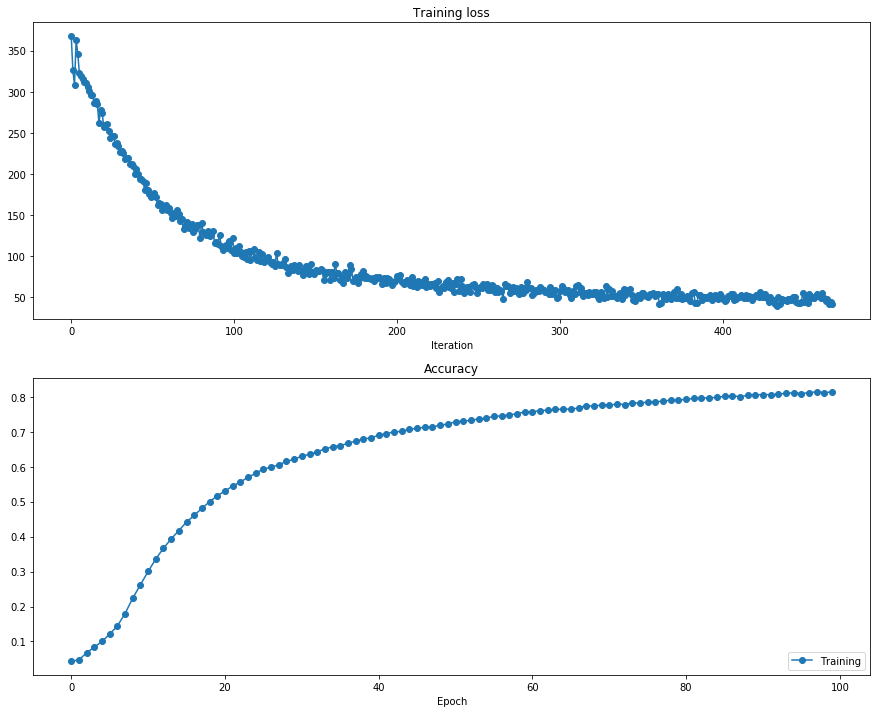

In [63]:
%reload_ext autoreload

opt_params, loss_hist, train_acc_hist = results

# Plot the learning curves
plt.subplot(2, 1, 1)
plt.title('Training loss')
loss_hist_ = loss_hist[1::100] # sparse the curve a bit
plt.plot(loss_hist_, '-o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(train_acc_hist, '-o', label='Training')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)

plt.show()

Now you can generate a text using the trained model. You can start from a specific word in the original text, such as `she`.

In [64]:
%reload_ext autoreload

# you can change the generated text length below.
text_length = 250

idx = 0
# you also can start from specific word. 
# since the words are all converted into lower case
idx = int(np.where(np.asarray(word_list) == 'Cat'.lower())[0])

# sample from the trained model
words = model.sample(idx, text_length-1)

# convert indices into words
output = [ word_list[i] for i in words]
print(' '.join(output))

cat were over the muggles started swarmin' around. he fell asleep as we was flyin' over bristol." dumbledore calmly. "voldemort had powers and his head. professor mcgonagall gasped. "lily and james... and dabbed at the potter's son, harry. but a tantrum and dundee have been phoning it had been broken at least twice. this man's name was albus dumbledore.  albus dumbledore didn't seem to realize he clicked it once, and twelve balls of blankets. inside, just visible, was you can't. i've been watching them  he dared tell her he'd have it was on his way back past them, clutching a large doughnut in his mind. to bed, he went to find the other end of the first thing he let himself into the other two. for a full minute the three of them stood and nighttime. mr. dursley loudly. the cat had had around its eyes. she, too, was dumbledore potter saying there were driven out of his mind by something else. as he looked simply too big to be allowed, and her good-for-nothing husband were as undursleyis

### Inline Question: Play around with different settings to get better understanding of its behavior and describe your observation. Make sure at least you cover the following points:
* Vanilla RNN vs LSTM (you can set different time steps and test with longer texts.)
* Problems in these approaches (there's no unique answer. just explain your own opinion from experiments.)
#### Ans: We know that practically, it is difficult to model long term dependencies using Vanilla RNNs and that LSTMs do the task better. LSTMs retain information for extended periods of time, and easily learn these long-term dependencies. After training an RNN and LSTM for a longer text, different time steps and epochs, I found that the behavior was consistent for all cases, in that that the RNN has appeared to perform better (Accuracy: 79.2% for one case) than the LSTM network (Accuracy: ~64% for the same settings). Also, LSTMs were slow to train than the RNN network. This can be attributed to the fact that LSTM introduces the four gates, and hence increased number of parametere, which in turn results in increased computation time. RNNs suffer from vanishing and exploding gradient problems. They cannot model very long sequences if using tanh as an activation function, and are very unstable if they use relu as an activation function. In LSTMs, there is no multiplication with weight matrix W but rather element-wise multiplication with the forget gate which makes LSTMs less prone to the vanishing gradient problem.